# Some Toy Models

# Start with some standard imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

# Example 1: Choosing an Objective Function

# This Creates our Data

In [2]:
N = 10000
noise = 1.5
X = np.random.randn(N,1)
def f(X):
    return np.sign(X)*np.interp(np.abs(X),[0.0,0.6,2.0],[0.0,0.6,0.65])
Y = f(X)+noise*np.random.randn(N,1)


Text(0.5, 1.0, 'Regplot of Y~X')

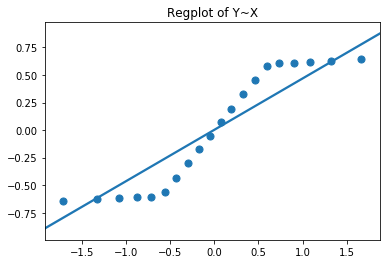

In [3]:
ax = sns.regplot(X.reshape(X.shape[0]),f(X).reshape(X.shape[0]),x_bins=20)
ax.set_title('Regplot of Y~X')

# Some functions for constructing trades, etc.

In [4]:
def loss(Yhat, Y, cost = 0.5):
    l = np.maximum(0.0,-(Y-cost)*np.sign(Yhat-cost))
    return l

def make_trades(Yhat, cost = 0.5):
    out = np.where(np.abs(Yhat) > cost,np.sign(Yhat),0.0)
    return out

def pnl_trades(trades, Y, cost = 0.5):
    return trades*Y - cost*np.abs(trades)

def empirical_loss(beta):
    Yhat = beta*X
    return np.mean(loss(Yhat,Y))

# Fit an Ordinary Least Squares (OLS) Regression

In [5]:
mdl = LinearRegression(fit_intercept = True)
mdl.fit(X,Y)
Yhat = mdl.predict(X)

# Best Estimator without Seeing the Future

In [6]:
Ybest = f(X)

# Let's Look at how our New Loss Varies with Beta. The vertical Bar is the Value of Beta from the OLS Regression

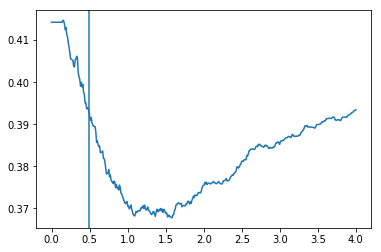

In [7]:
beta_vals = np.linspace(0,4,400)
losses = np.zeros(beta_vals.shape)
for i in range(losses.shape[0]):
    losses[i] = empirical_loss(beta_vals[i])
plt.axvline(x=mdl.coef_)
ax=plt.plot(beta_vals,losses)

# Take the value of beta that minimizes the loss

In [8]:
beta_optim = beta_vals[np.argmin(losses)]

# Generate out-of-sample Data

In [9]:
N = 10000
K = 2
noise = 1.0
cost = 1.0
X = np.random.randn(N,1)
Y = f(X)+noise*np.random.randn(N,1)

In [10]:
Yhat = mdl.predict(X)
trades = make_trades(Yhat,cost = 0.5)
pnl = pnl_trades(trades,Y,cost = 0.5)
eqline = np.cumsum(pnl)

In [11]:
Yhat_optim = beta_optim*X
trades_optim = make_trades(Yhat_optim,cost = 0.5)
pnl_optim = pnl_trades(trades_optim,Y,cost = 0.5)
eqline_optim = np.cumsum(pnl_optim)

In [12]:
Ybest = f(X)
trades_best = make_trades(Ybest,cost = 0.5)
pnl_best= pnl_trades(trades_best,Y,cost = 0.5)
eqline_best = np.cumsum(pnl_best)

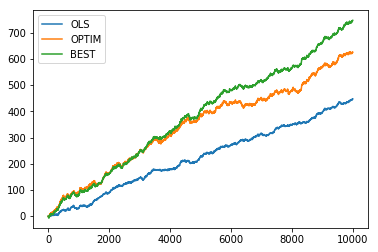

In [13]:
ax=plt.plot(eqline)
plt.plot(eqline_optim)
plt.plot(eqline_best)
plt.legend(['OLS','OPTIM','BEST'])

# Example 2: Correlated Samples

# Define some functions

In [14]:

def fillf(Z):
    out = np.empty(Z.shape)
    last=Z[0]
    for i in range(len(Z)):
        if np.isnan(Z[i]):
            out[i] = last
        else:
            out[i] = Z[i]
            last = Z[i]
    return out

def sum_days(pnl,K):
    out = np.zeros(pnl.shape[0]//int(K))
    i = -1
    for j in range(pnl.shape[0]):
        if j % (K)==0:
            i+=1
        out[i]+=pnl[j]
        
    return out

def get_eqline(pred, Ytot, K = 1000):
    pnl = np.sign(pred)*Ytot
    pnl_day = sum_days(pnl,K)
    pnl_day = pnl_day.reshape(pnl_day.shape[0],1)
    eLine = np.cumsum(pnl_day)
    return eLine


# Generate our Data 

# N is the number of 'days'. K is the number of samples per day. There is one sample of Z per day. Ytot includes Z, and Y is the residual


In [15]:
def generate_samples(N,K = 1000):
    T = N*K
    Z0 = 0.01*np.random.randn(N,1)+0.00000
    Z = np.empty((T,1))
    Z[:] = np.nan
    Z[(np.arange(T) % K == 0)] = Z0
    Z = fillf(Z)
    X = np.random.randn(T,1)
    Y = 0.0004*X+0.005*np.random.randn(T,1)
    Ytot = Y+Z
    return Y, Ytot, Z, X

Y,Ytot,Z, X = generate_samples(20)

# Fit to either Ytot or Y

In [16]:
mdl = LinearRegression(fit_intercept=True)
mdl.fit(X,Ytot)

mdl2 = LinearRegression(fit_intercept=True)
mdl2.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Generate out-of-sample Data

In [17]:
Y,Ytot,Z, X = generate_samples(250)

# Generate Predictions and Trades

In [18]:
Ytot_hat = mdl.predict(X)
Y_hat = mdl2.predict(X)

In [19]:
eLine_unhedged = get_eqline(Ytot_hat, Ytot, K = 1000)
eLine_hedged = get_eqline(Y_hat, Ytot, K = 1000)

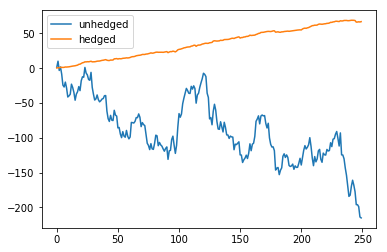

In [20]:
ax=plt.plot(eLine_unhedged)
plt.plot(eLine_hedged)
plt.legend(['unhedged','hedged'])

In [21]:
num_sims = 100
unhedged_pnl = np.zeros(num_sims)
hedged_pnl = np.zeros(num_sims)
for i in range(num_sims):
    if i % 10 ==0:
        print('iteration = ',i)
    Y,Ytot,Z, X = generate_samples(20)
    mdl = LinearRegression(fit_intercept=True)
    mdl.fit(X,Ytot)
    mdl2 = LinearRegression(fit_intercept=True)
    mdl2.fit(X,Y)
    Y,Ytot,Z, X = generate_samples(250)
    Ytot_hat = mdl.predict(X)
    Y_hat = mdl2.predict(X)
    eLine_unhedged = get_eqline(Ytot_hat, Ytot, K = 1000)
    eLine_hedged = get_eqline(Y_hat, Ytot, K = 1000)
    unhedged_pnl[i] = eLine_unhedged[-1]
    hedged_pnl[i] = eLine_hedged[-1]

iteration =  0
iteration =  10
iteration =  20
iteration =  30
iteration =  40
iteration =  50
iteration =  60
iteration =  70
iteration =  80
iteration =  90


# Distribution of Cumulative Profit for hedged versus unhedged models

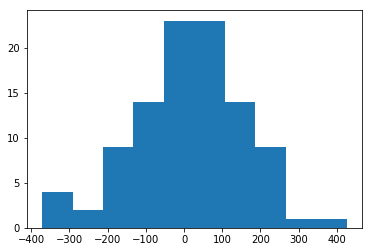

In [22]:
_=plt.hist(unhedged_pnl)

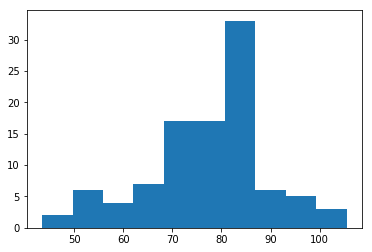

In [23]:
_=plt.hist(hedged_pnl)

In [25]:
print('mean hedged pnl = ',np.mean(hedged_pnl))
print('std dev of hedged pnl = ',np.std(hedged_pnl))
print('hedged information ratio = ',np.mean(hedged_pnl)/np.std(hedged_pnl))

print('mean unhedged pnl = ',np.mean(unhedged_pnl))
print('std dev of unhedged pnl = ',np.std(unhedged_pnl))
print('unhedged information ratio = ',np.mean(unhedged_pnl)/np.std(unhedged_pnl))

mean hedged pnl =  77.43076218064226
std dev of hedged pnl =  12.04728327351754
hedged information ratio =  6.42723844228444
mean unhedged pnl =  14.473478158681743
std dev of unhedged pnl =  142.6180167382802
unhedged information ratio =  0.10148421980402499
